In [1]:
import os 
import json
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
import tqdm
import numpy as np
from matplotlib import pyplot as plt
# from matplotlib.nxutils import points_inside_poly
from make_imagenet_64_c import *
from torchattacks import FGSM, PGD

In [2]:
readPath = '/Users/ali/Desktop/objectnet-1.0/images/'

In [4]:
objsNames = {'chair':0, 'broom':1, 'candle':2, 'basket':3, 'banana':4, 'iron_for_clothes':5, 'plate':6, 'fan':7, 'toaster':8, 't-shirt':9}

In [5]:
objs = list(objsNames.keys())

In [62]:
# train_data, val_data = [], [] 
# for ob in objs:
#     files = os.listdir(os.path.join(readPath,ob))
#     count_train = 0
#     for i in files:
#         if i.endswith('.json'):
#             with open(os.path.join(readPath,ob,i), 'r') as j:
#                  contents = json.loads(j.read())        
#                  if count_train < 70:   
#                      train_data.append((os.path.join(readPath,ob,contents['imagePath']),contents['shapes'][0]['points'],objsNames[ob]))    
#                      count_train += 1
#                  else:
#                      if count_train <100:   
#                          val_data.append((os.path.join(readPath,ob,contents['imagePath']),contents['shapes'][0]['points'],objsNames[ob]))                    
#                      count_train += 1                    

                        

In [63]:
# with open('./models/train_data.npy', 'wb') as f:
#     np.save(f, train_data, allow_pickle=True)
    
# with open('./models/val_data.npy', 'wb') as f:
#     np.save(f, val_data, allow_pickle=True)    

In [6]:
with open('./models/train_data.npy', 'rb') as f:
    train_data = np.load(f,allow_pickle=True)

with open('./models/val_data.npy', 'rb') as f:
    val_data = np.load(f,allow_pickle=True)


In [7]:
train_data[90][2]

1

In [7]:
ls '/Users/ali/Desktop/objectnet-1.0/images/chair/3752c56713a54da.json'

ls: /Users/ali/Desktop/objectnet-1.0/images/chair/3752c56713a54da.json: No such file or directory


In [8]:
def crop_mask(img, pts_lst):
    img_array = np.asarray(img)
#             print(img_array.shape)
#             width, height = img.size
    # polygon = [(x1,y1),(x2,y2),...] or [x1,y1,x2,y2,...]
    # width = ?
    # height = ?

    pts = np.array(pts_lst)
    pts = pts.astype('int')
#             print(pts)

    # read image as RGB (without alpha)
#             img = Image.open("crop.jpg").convert("RGB")

    # convert to numpy (for convenience)
#             img_array = numpy.asarray(img)

    # create mask
    polygon =  [(u[0],u[1]) for u  in pts] #  [(40,203),(623,243),(691,177),(581,26),(482,42)]
#             print(polygon)
    # create new image ("1-bit pixels, black and white", (width, height), "default color")
    mask_img = Image.new('1', (img_array.shape[1], img_array.shape[0]), 0)

    ImageDraw.Draw(mask_img).polygon(polygon, outline=1, fill=1)
    mask = np.array(mask_img)

    # assemble new image (uint8: 0-255)
    new_img_array = np.ones(img_array.shape, dtype='uint8')

    # copy color values (RGB)
    new_img_array[:,:,:3] = img_array[:,:,:3]

    # filtering image by mask
    new_img_array[:,:,0] = new_img_array[:,:,0] * mask
    new_img_array[:,:,1] = new_img_array[:,:,1] * mask
    new_img_array[:,:,2] = new_img_array[:,:,2] * mask

    # back to Image from numpy
    img = Image.fromarray(new_img_array, "RGB")

    return img

# Training the models

In [9]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


In [10]:
from matplotlib.path import Path
class MyDataset(Dataset):
    def __init__(self, data_dict, transform=None, phase='train', case='full'):
        self.data_dict = data_dict
        self.phase = phase                
        self.case = case 
        self.transform = ds_trans

    def __len__(self):
        return len(self.data_dict)

    def __getitem__(self, idx):
        img_path = self.data_dict[idx][0]
        img = Image.open(img_path).convert('RGB')
        
#         import pdb; pdb.set_trace()
        # do more stuff here
#         print([pts])
        if self.case == 'box':
            pts = np.array(self.data_dict[idx][1])
            pts = pts.astype('int')
            min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
#             print([min_x, max_x, min_y, max_y])
#             print(img.width)
            img = img.crop([min_x, min_y, max_x, max_y])    

        if self.case == 'seg':
            img = crop_mask(img, self.data_dict[idx][1])
            # now cut the box region
            pts = np.array(self.data_dict[idx][1])
            pts = pts.astype('int')
            min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
            img = img.crop([min_x, min_y, max_x, max_y])    

        
        img_transformed = self.transform(img)
        
        return img_transformed, torch.tensor(self.data_dict[idx][2])

In [22]:
train_ds = MyDataset(train_data, ds_trans, case='seg')
val_ds = MyDataset(val_data, ds_trans, case='seg')
train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_ds, batch_size=4, shuffle=True, num_workers=4)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

In [33]:
u, v = train_ds[0]

In [34]:
u = transforms.ToTensor()(u)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


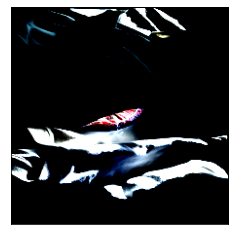

In [49]:
plt.imshow(u.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()

In [38]:
u.shape

torch.Size([3, 224, 224])

In [27]:
# print((u.mean(axis=0)>0).sum()*1.0 / (u.mean(axis=0)>=0).sum()*1.0)
u.shape[0]*u.shape[1]

672

# Calculate stats

In [40]:
len(val_ds)

300

In [54]:
# get the stats
frac = []
for u,v in val_ds:
     u = transforms.ToTensor()(u)
#      frac.append(u.shape[0]*u.shape[1])        
     frac.append((u.mean(axis=0)>0).sum()*1.0 / (u.mean(axis=0)>=0).sum()*1.0)
        

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [52]:
(u.mean(axis=0)>0).sum()
# (u.mean(axis=0)>0).shape
224*224

50176

In [53]:
(u.mean(axis=0)>=0).sum()*1.0
# u.min()

tensor(-2.1179)

In [166]:
box_areas = frac

In [ ]:
(np.array(box_areas)/np.array(frac)).mean()

In [23]:
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# resnet.load_state_dict(torch.load('./models/full.pth'))

In [15]:
# iter(next(train_dataloader))

In [24]:
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs, save_path):

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    net.train()
    # boost network speed on gpu
    torch.backends.cudnn.benchmark = True
    
    phase = 'train'

    for epoch in range(num_epochs):
            print("Epoch {}/{}".format(epoch+1, num_epochs))

            epoch_loss = 0.0
            epoch_corrects = 0


            for inputs, labels in dataloader_dict[phase]:
#                 import pdb; pdb.set_trace()
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    labels = labels
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, axis=1)

                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item() * inputs.shape[0]
                    epoch_corrects += torch.sum(preds==labels.data)


            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print("{} Loss: {:.4f}, Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))

    torch.save(net.state_dict(), save_path)

In [67]:
# torch.save(resnet.state_dict(), './models/seg.pth')

In [25]:
train_model(resnet, dataloader_dict, criterion, optimizer, 5, './models/box.pth')

device: cpu
Epoch 1/5
train Loss: 1.7646, Acc: 0.4143
Epoch 2/5
train Loss: 0.9030, Acc: 0.7271
Epoch 3/5
train Loss: 0.6321, Acc: 0.8057
Epoch 4/5
train Loss: 0.3664, Acc: 0.8943
Epoch 5/5
train Loss: 0.3855, Acc: 0.8843


In [ ]:
# for u,v in dataloader_dict['train']:
#     print(u)

In [19]:
def test_model_clean(net, dataloader_dict):
    correct = 0
    total = 0

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    net.eval()
    
    
    for images, labels in dataloader_dict['val']:    
        # images = (images-images.min()) / (images.max()-images.min())
        images, labels = images.to(device), labels.to(device)         
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
    #     correct += (predicted == labels.cuda()).sum()
        correct += (predicted == labels).sum()

    acc = float(correct) / total
        
    return acc#, images    

In [70]:
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/box.pth'))

<All keys matched successfully>

In [26]:
# load_path
# load_model(resnet, load_path)
test_model_clean(resnet, dataloader_dict)

device: cpu


0.7766666666666666

# Distortion analysis

In [10]:
import collections

print('\nUsing ObjectNet data')

distortions = [
    'gaussian_noise', 
    'shot_noise', 
    'impulse_noise',
    'defocus_blur', 
    'glass_blur', 
    'motion_blur', 
    'zoom_blur',
    'snow', 
    'frost', 
    'fog', 
    'brightness',
    'contrast', 
    'elastic_transform', 
    # 'pixelate', 
    'jpeg_compression',
    # 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate'
]
transform = transforms.Compose([
#         transforms.CenterCrop(224),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


Using ObjectNet data


In [16]:
kind = 'seg'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/'+kind+'.pth'))

<All keys matched successfully>

In [27]:
apply_mask = True
device = 'cpu'
resnet.eval()
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
error_rates = dict()
for distortion in distortions:
  print(distortion + '\n')
  error_rates[distortion] = [] 
#     error_rates_distortion = dict() 
  
  for severity in range(1,4):
      print(str(severity))        
#         error_rates_distortion[severity] = []

      res_top1, res_top5 = [], []
      correct = 0
      total = 0

      # for n, category in enumerate(data):
      for img_path, polygon, label in val_data:    
          images = Image.open(img_path).convert('RGB')
#             import pdb; pdb.set_trace()
#             images, labels = images[0].to(device), labels.to(device)         
          #images = np.array(img)#.permute(1,2,0)
          if kind == 'box':
              pts = np.array(polygon)
              pts = pts.astype('int')
              min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
  #             print([min_x, max_x, min_y, max_y])
  #             print(img.width)
              images = images.crop([min_x, min_y, max_x, max_y])    
  
          if kind == 'seg':
              images = crop_mask(images, polygon)
              pts = np.array(polygon)
              pts = pts.astype('int')
              min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
  #             print([min_x, max_x, min_y, max_y])
  #             print(img.width)
              images = images.crop([min_x, min_y, max_x, max_y])                  
        
              mask = np.array(images.copy())
              mask[mask>0] = 1
              mask = Image.fromarray(mask)
              mask = mask.resize((224, 224))  
              mask = np.array(mask)  
              mask = mask.mean(axis=2)        
            #     with torch.no_grad():                    
                
                

          images = images.resize((224, 224))
          
          exr = distortion + '(images,severity)'
          aa = torch.Tensor(eval(exr))
            
          if apply_mask:
               aa[:,:,0] = aa[:,:,0] * mask         
               aa[:,:,1] = aa[:,:,1] * mask 
               aa[:,:,2] = aa[:,:,2] * mask 
            
            
        
#           import pdb; pdb.set_trace()
          images = transform((aa/255).numpy()) # range [0,1]
             
#             import pdb; pdb.set_trace()    

          outputs = resnet(images[None])
          _, predicted = torch.max(outputs.data, 1)

          total += 1#label.size(0)
      #     correct += (predicted == labels.cuda()).sum()
          correct += (predicted == label).sum()

      acc = float(correct) / total
                  
      # after severity
          
      error_rates[distortion].append(acc)    
  print(error_rates[distortion])

gaussian_noise

1
2
3
[0.7666666666666667, 0.72, 0.6566666666666666]
shot_noise

1
2
3
[0.7633333333333333, 0.7266666666666667, 0.7066666666666667]
impulse_noise

1
2
3
[0.67, 0.65, 0.6133333333333333]
defocus_blur

1
2
3
[0.7866666666666666, 0.7833333333333333, 0.76]
glass_blur

1
2
3
[0.7866666666666666, 0.7933333333333333, 0.7733333333333333]
motion_blur

1
2
3
[0.7933333333333333, 0.8066666666666666, 0.7833333333333333]
zoom_blur

1
2
3
[0.7333333333333333, 0.7066666666666667, 0.6733333333333333]
snow

1
2
3
[0.6933333333333334, 0.7, 0.6366666666666667]
frost

1
2
3
[0.7266666666666667, 0.7133333333333334, 0.6833333333333333]
fog

1
2
3
[0.7733333333333333, 0.74, 0.7366666666666667]
brightness

1
2
3
[0.7833333333333333, 0.7666666666666667, 0.7233333333333334]
contrast

1
2
3
[0.7266666666666667, 0.6833333333333333, 0.6333333333333333]
elastic_transform

1
2
3
[0.7833333333333333, 0.7833333333333333, 0.7966666666666666]
jpeg_compression

1
2
3
[0.7833333333333333, 0.78, 0.776666666

# 

In [31]:

#Full
full_res =  np.array([[0.59, 0.49, 0.39, 0.3466666666666667],
[0.5766666666666667, 0.5266666666666666, 0.45, 0.39666666666666667],
[0.55, 0.49333333333333335, 0.38333333333333336, 0.24666666666666667],
[0.63, 0.5966666666666667, 0.6033333333333334, 0.52],
[0.6333333333333333, 0.62, 0.6033333333333334, 0.5633333333333334],
[0.6366666666666667, 0.6366666666666667, 0.6066666666666667, 0.5933333333333334],
[0.6366666666666667, 0.6033333333333334, 0.5933333333333334, 0.5166666666666667],
[0.5666666666666667, 0.5133333333333333, 0.49333333333333335, 0.43333333333333335],
[0.5733333333333334, 0.48, 0.5033333333333333, 0.39],
[0.6166666666666667, 0.6066666666666667, 0.59, 0.5166666666666667],
[0.6333333333333333, 0.62, 0.58, 0.47333333333333333],
[0.5366666666666666, 0.46, 0.41, 0.15],
[0.65, 0.6533333333333333, 0.6533333333333333, 0.39666666666666667],
[0.6333333333333333, 0.62, 0.61, 0.59]])


#BOX
box_res =  np.array([[0.7766666666666666, 0.68, 0.5733333333333334, 0.39666666666666667],
[0.7566666666666667, 0.71, 0.6833333333333333, 0.4533333333333333],
[0.6133333333333333, 0.5666666666666667, 0.49666666666666665,0.26],
[0.7733333333333333, 0.7733333333333333, 0.7566666666666667,0.66],
[0.77, 0.7633333333333333, 0.75,0.71],
[0.78, 0.7666666666666667, 0.76, 0.7366666666666667],
[0.6933333333333334, 0.6033333333333334, 0.5366666666666666, 0.36333333333333334],
[0.59, 0.56, 0.48, 0.5366666666666666],
[0.7033333333333334, 0.66, 0.5966666666666667, 0.51],
[0.8033333333333333, 0.7833333333333333, 0.7566666666666667, 0.6733333333333333],
[0.7866666666666666, 0.7633333333333333, 0.7433333333333333, 0.62],
[0.74, 0.6833333333333333, 0.5633333333333334, 0.21],
[0.7833333333333333, 0.77, 0.77, 0.59],
[0.7833333333333333, 0.78, 0.7833333333333333, 0.7166666666666667]])


#Seg
seg_res =  np.array([[0.76, 0.7366666666666667, 0.6633333333333333, 0.6266666666666667],
[0.7666666666666667, 0.73, 0.7133333333333334, 0.6866666666666666],
[0.6066666666666667, 0.58, 0.5833333333333334, 0.5766666666666667],
[0.7933333333333333, 0.7866666666666666, 0.7766666666666666, 0.7366666666666667],
[0.7933333333333333, 0.79, 0.7833333333333333, 0.7666666666666667],
[0.8033333333333333, 0.7866666666666666, 0.78, 0.78],
[0.7466666666666667, 0.6733333333333333, 0.6366666666666667, 0.55],
[0.66, 0.65, 0.5433333333333333, 0.46],
[0.73, 0.6933333333333334, 0.66, 0.6466666666666666],
[0.78, 0.7333333333333333, 0.7133333333333334, 0.6533333333333333],
[0.79, 0.7666666666666667, 0.7533333333333333, 0.6966666666666667],
[0.71, 0.6733333333333333, 0.6266666666666667, 0.39],
[0.8, 0.7933333333333333, 0.8, 0.74],
[0.7766666666666666, 0.7866666666666666, 0.7866666666666666, 0.77]])


seg_res_mask =  np.array([[0.7666666666666667, 0.72, 0.6566666666666666,0.6566666666666666],
[0.7633333333333333, 0.7266666666666667, 0.7066666666666667,0.6633333333333333],
[0.67, 0.65, 0.6133333333333333, 0.62,],
[0.7866666666666666, 0.7833333333333333, 0.76, 0.71],
[0.7866666666666666, 0.7933333333333333, 0.773333333333333, 0.75],
[0.7933333333333333, 0.8066666666666666, 0.7833333333333333,0.7733333333333333],
[0.7333333333333333, 0.7066666666666667, 0.6733333333333333,0.6266666666666667],
[0.6933333333333334, 0.7, 0.6366666666666667, 0.5866666666666667],
[0.7266666666666667, 0.7133333333333334, 0.6833333333333333, 0.6466666666666666],
[0.7733333333333333, 0.74, 0.7366666666666667,  0.6866666666666666],
[0.7833333333333333, 0.7666666666666667, 0.7233333333333334,0.71],
[0.7266666666666667, 0.6833333333333333, 0.6333333333333333, 0.5233333333333333],
[0.7833333333333333, 0.7833333333333333, 0.7966666666666666,0.74],
[0.7833333333333333, 0.78, 0.7766666666666666,0.7733333333333333]])



([<matplotlib.axis.XTick at 0x1a2a513f10>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

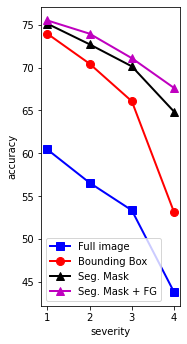

In [38]:
fig = plt.figure(figsize=[2.5, 5.5])
plt.plot(np.mean(full_res, axis=0)*100, color='b', marker= 's', linewidth=2, markersize= 8)
plt.plot(np.mean(box_res, axis=0)*100, color='r', marker= 'o', linewidth=2, markersize= 8)
plt.plot(np.mean(seg_res, axis=0)*100, color='black', marker= '^', linewidth=2, markersize= 8)
plt.plot(np.mean(seg_res_mask, axis=0)*100, color='m', marker= '^', linewidth=2, markersize= 8)
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask', 'Seg. Mask + FG'])
plt.xlabel('severity')
plt.ylabel('accuracy')
plt.xticks([ 0, 1, 2, 3], [ 1, 2, 3, 4])    

# Adversarial perturbation analysis

In [7]:
with open('./models/val_data.npy', 'rb') as f:
    val_data = np.load(f,allow_pickle=True)


In [8]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


In [10]:
# del resnet
# del resnet_copy

kind = 'seg'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/'+kind+'.pth'))


resnet_copy = models.resnet18(pretrained=True)
num_ftrs = resnet_copy.fc.in_features
resnet_copy.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet_copy.load_state_dict(torch.load('./models/'+kind+'.pth'))

<All keys matched successfully>

> <ipython-input-12-df01f7172fa4>(41)<module>()
-> imin = image.min()


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(42)<module>()
-> imax = image.max()


(Pdb)  imin


tensor(-2.1179)


(Pdb)  imax


*** NameError: name 'imax' is not defined


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(43)<module>()
-> image = (image - imin) / (imax - imin)


(Pdb)  imax


tensor(2.2489)


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(44)<module>()
-> inputs_adv = attack(image.detach(), torch.tensor([label]))


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(45)<module>()
-> inputs_adv = inputs_adv * (imax  - imin) + imin


(Pdb)  plt.imshow(inputs_adv[0].permute(1,2,0)); plt.show()


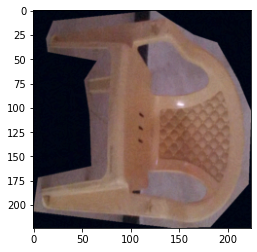

(Pdb)  inputs_adv.max()


tensor(1.)


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(48)<module>()
-> if apply_mask:


(Pdb)  plt.imshow(inputs_adv[0].permute(1,2,0)); plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


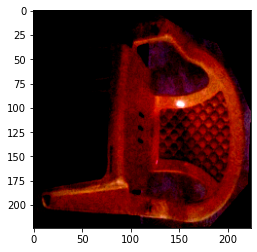

(Pdb)  n


> <ipython-input-12-df01f7172fa4>(49)<module>()
-> inputs_adv[0,0] = inputs_adv[0,0] * mask


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(50)<module>()
-> inputs_adv[0,1] = inputs_adv[0,1] * mask


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(51)<module>()
-> inputs_adv[0,2] = inputs_adv[0,2] * mask


(Pdb)  n


> <ipython-input-12-df01f7172fa4>(53)<module>()
-> with torch.set_grad_enabled(False):


(Pdb)  plt.imshow(inputs_adv[0].permute(1,2,0)); plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


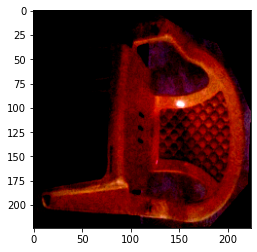

(Pdb)  q


BdbQuit: 

In [12]:
eps = 2/255
correct = 0
total = 0
 
# attack =FGSM(resnet_copy, eps=eps)
attack = PGD(resnet_copy, eps=eps, alpha=8/255, iters=5)      
resnet.eval()

apply_mask = True

for (img_path, polygon, label) in val_data:    
    image = Image.open(img_path).convert('RGB')
    
    if kind == 'box':
      pts = np.array(polygon)
      pts = pts.astype('int')
      min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
      image = image.crop([min_x, min_y, max_x, max_y])    

    if kind == 'seg':
      image = crop_mask(image, polygon)
      pts = np.array(polygon)
      pts = pts.astype('int')
      min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
      image = image.crop([min_x, min_y, max_x, max_y])                  
      mask = np.array(image)
      mask[mask>0] = 1
#       import pdb; pdb.set_trace()
      mask = Image.fromarray(mask)
      mask = mask.resize((224, 224))  
      mask = np.array(mask)  
      mask = mask.mean(axis=2)
    
#     image = image.resize((224, 224))
    image = ds_trans(image)
#     image = np.array(image)
    image = image.unsqueeze(0)
    import pdb; pdb.set_trace()
#     image = image.permute(0,3,1,2)
    
    imin = image.min() 
    imax = image.max()     
    image = (image - imin) / (imax - imin)
    inputs_adv = attack(image.detach(), torch.tensor([label]))
    inputs_adv = inputs_adv * (imax  - imin) + imin
    
#     import pdb; pdb.set_trace()
    if apply_mask:
       inputs_adv[0,0] = inputs_adv[0,0] * mask         
       inputs_adv[0,1] = inputs_adv[0,1] * mask 
       inputs_adv[0,2] = inputs_adv[0,2] * mask 
#     with torch.no_grad():        
    with torch.set_grad_enabled(False):
        output = resnet(inputs_adv)

    #         outputs = net(images)
    _, predicted = torch.max(output.data, 1)

    total += 1 #label.size(0)
    #     correct += (predicted == labels.cuda()).sum()
    correct += (predicted == label).sum()

    acc = float(correct) / total
print(acc)

In [36]:
full_res_fgsm = np.array([0.18666666666666668, 0.043333333333333335, 0.04666666666666667])
full_res_pgd = np.array([0.18333333333333332, 0.03666666666666667,0.0033333333333333335])                       
box_res_fgsm =  np.array([0.41, 0.19333333333333333, 0.16])
box_res_pgd =  np.array([0.41, 0.07, 0.0])


seg_res_fgsm = np.array([0.5866666666666667, 0.3, 0.21])
seg_res_pgd = np.array([0.58, 0.14666666666666667, 0.023333333333333334])



seg_res_masked_fgsm = np.array([0.5633333333333334,0.36333333333333334, .3])
seg_res_masked_pgd = np.array([0.5633333333333334,0.26666666666666666,0.14333333333333334])

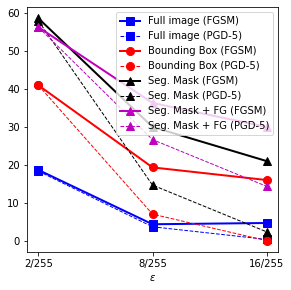

In [37]:
fig = plt.figure(figsize=[4.5, 4.5])
# plt.bar(np.arange(len(full_res_2)), full_res_2*100, .1, color='b')#, marker= 's', linewidth=2, markersize= 8)
# plt.bar(np.arange(len(full_res_8)), full_res_8*100, .1, color='b')#, marker= 's', linewidth=2, markersize= 8)
plt.plot(full_res_fgsm*100, color='b', marker= 's', linewidth=2,linestyle = '-', markersize= 8)
plt.plot(full_res_pgd*100, color='b', marker= 's', linewidth=1, linestyle = '--', markersize= 8)

plt.plot(box_res_fgsm*100, color='r', marker= 'o', linewidth=2, markersize= 8)
plt.plot(box_res_pgd*100, color='r', marker= 'o', linewidth=1, linestyle = '--', markersize= 8)


plt.plot(seg_res_fgsm*100, color='k', marker= '^', linewidth=2, markersize= 8)
plt.plot(seg_res_pgd*100, color='k', marker= '^', linewidth=1, linestyle = '--', markersize= 8)

plt.plot(seg_res_masked_fgsm*100, color='m', marker= '^', linewidth=2, markersize= 8)
plt.plot(seg_res_masked_pgd*100, color='m', marker= '^', linewidth=1, linestyle = '--', markersize= 8)


# plt.plot(np.mean(box_res, axis=0)*100, color='r', marker= 'o', linewidth=2, markersize= 8)
# plt.plot(np.mean(seg_res, axis=0)*100, color='black', marker= '^', linewidth=2, markersize= 8)
# plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])
plt.xlabel(r'$\epsilon$')
plt.xticks([0,1,2],['2/255','8/255','16/255'])
# plt.xtick_labels(['2/255','8/255'])
plt.legend(['Full image (FGSM)', 'Full image (PGD-5)', 'Bounding Box (FGSM)', 'Bounding Box (PGD-5)', 'Seg. Mask (FGSM)', 'Seg. Mask (PGD-5)', 'Seg. Mask + FG (FGSM)', 'Seg. Mask + FG (PGD-5)'])

# plt.

In [113]:
kind

'seg'

# geometric analysis

In [8]:
with open('./models/val_data.npy', 'rb') as f:
    val_data = np.load(f,allow_pickle=True)


In [9]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


In [72]:
# del resnet

kind = 'seg'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/'+kind+'.pth'))


<All keys matched successfully>

### scale

In [74]:
resnet.eval()

accs = []
print(kind)

# scaling
for scale in [.1, .2, .3, .4, .6, .7, .8, .9, 1, 1.5, 5]:
    print(scale)
    correct = 0
    total = 0    
    for (img_path, polygon, label) in val_data:    
        image = Image.open(img_path).convert('RGB')

        if kind == 'box':
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])    

        if kind == 'seg':
          image = crop_mask(image, polygon)
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])                  

        w, h = np.array(image.size)*scale
        image = image.resize((int(w),int(h)),Image.ANTIALIAS)
#         import pdb; pdb.set_trace()
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)

seg
0.1
0.6466666666666666
0.2
0.76
0.3
0.7833333333333333
0.4
0.7933333333333333
0.6
0.7933333333333333
0.7
0.8033333333333333
0.8
0.8
0.9
0.8
1
0.7966666666666666
1.5
0.8
5
0.8
[0.6466666666666666, 0.76, 0.7833333333333333, 0.7933333333333333, 0.7933333333333333, 0.8033333333333333, 0.8, 0.8, 0.7966666666666666, 0.8, 0.8]


In [25]:
np.array(image.size)*2

TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'int'

In [ ]:
import PIL

### rotation

In [77]:
resnet.eval()

accs = []
print(kind)
import PIL

# scaling
for angle in [-90, -60, -45, -30, 0, 30, 45, 60, 90]: 
    print(angle)
    correct = 0
    total = 0    
    for (img_path, polygon, label) in val_data:    
        image = Image.open(img_path).convert('RGB')

        if kind == 'box':
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])    

        if kind == 'seg':
          image = crop_mask(image, polygon)
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])                  

#         w, h = np.array(image.size)*scale
#         image = image.resize((int(w),int(h)),Image.ANTIALIAS)
        image = image.rotate(angle, PIL.Image.NEAREST, expand = 1) 
#         import pdb; pdb.set_trace()
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)# rotating a image 90 deg counter clockwise 

  

seg
-90
0.72
-60
0.71
-45
0.6933333333333334
-30
0.7066666666666667
0
0.7966666666666666
30
0.74
45
0.7
60
0.7066666666666667
90
0.75
[0.72, 0.71, 0.6933333333333334, 0.7066666666666667, 0.7966666666666666, 0.74, 0.7, 0.7066666666666667, 0.75]


In [30]:
import PIL.Image.NEAREST

ModuleNotFoundError: No module named 'PIL.Image.NEAREST'; 'PIL.Image' is not a package

### translation

In [81]:
resnet.eval()

accs = []

a = 1
b = 0
c = 0 #left/right (i.e. 5/-5)
d = 0
e = 1
f = 0 #up/down (i.e. 5/-5)

print(kind)

# scaling
for c in [50, 40, 30, 20, 10, 0, -10, -20, -30, -40, -50]: # to the left
    print(c)
    correct = 0
    total = 0    
    for (img_path, polygon, label) in val_data:    
        image = Image.open(img_path).convert('RGB')

        if kind == 'box':
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])    

        if kind == 'seg':
          image = crop_mask(image, polygon)
          pts = np.array(polygon)
          pts = pts.astype('int')
          min_x, max_x, min_y, max_y =  pts[:,0].min(), pts[:,0].max(), pts[:,1].min(), pts[:,1].max()      
          image = image.crop([min_x, min_y, max_x, max_y])                  

#         w, h = np.array(image.size)*scale
#         image = image.resize((int(w),int(h)),Image.ANTIALIAS)
#         import pdb; pdb.set_trace()
        image = image.resize((224, 224))
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))    
        
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)# rotating a image 90 deg counter clockwise 

  

seg
50
0.76
40
0.77
30
0.7866666666666666
20
0.78
10
0.7833333333333333
0
0.7933333333333333
-10
0.7866666666666666
-20
0.7733333333333333
-30
0.79
-40
0.8
-50
0.7666666666666667
[0.76, 0.77, 0.7866666666666666, 0.78, 0.7833333333333333, 0.7933333333333333, 0.7866666666666666, 0.7733333333333333, 0.79, 0.8, 0.7666666666666667]


In [82]:
box_scale = np.array([0.6066666666666667, 0.7333333333333333, 0.7633333333333333, 0.7866666666666666, 0.7866666666666666, 0.7866666666666666, 0.79, 0.79, 0.7933333333333333,  0.79, 0.7866666666666666, 0.7866666666666666]) 
seg_scale = np.array([0.6466666666666666, 0.76, 0.7833333333333333, 0.7933333333333333, 0.7933333333333333, 0.8033333333333333, 0.8, 0.8, 0.7966666666666666, 0.8, 0.8])
full_scale =  np.array([0.6166666666666667, 0.64, 0.65, 0.65, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333, 0.6533333333333333])
box_rot =  np.array([0.6833333333333333,  0.59, 0.5966666666666667, 0.68, 0.79, 0.58, 0.6033333333333334, 0.59, 0.6733333333333333])
seg_rot = np.array([0.72, 0.71, 0.6933333333333334, 0.7066666666666667, 0.7966666666666666, 0.74, 0.7, 0.7066666666666667, 0.75]) 
full_rot = np.array([0.37, 0.43, 0.43666666666666665, 0.48333333333333334, 0.6533333333333333, 0.4633333333333333, 0.4766666666666667, 0.45666666666666667, 0.37]) 
box_trans = np.array([0.7, 0.7266666666666667, 0.7266666666666667, 0.66, 0.77, 0.7833333333333333, 0.7433333333333333, 0.71, 0.7066666666666667, 0.72, 0.6733333333333333])
seg_trans =np.array([0.76, 0.77, 0.7866666666666666, 0.78, 0.7833333333333333, 0.7933333333333333, 0.7866666666666666, 0.7733333333333333, 0.79, 0.8, 0.7666666666666667])
full_trans =np.array([0.61, 0.64, 0.6366666666666667, 0.64, 0.6433333333333333, 0.6366666666666667, 0.65, 0.65, 0.65, 0.64, 0.6266666666666667])



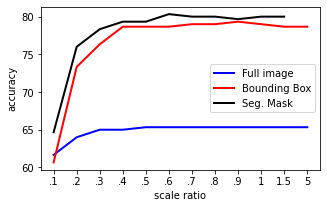

In [83]:
fig = plt.figure(figsize=[5, 3])

# plt.plot(seg_res_2*100, color='k', marker= '^', linewidth=2, markersize= 8)
# plt.plot(seg_res_8*100, color='k', marker= '^', linewidth=1, linestyle = '--', markersize= 8)


plt.plot(full_scale*100, color='b', linewidth=2)
plt.plot(box_scale*100, color='r', linewidth=2)
plt.plot(seg_scale*100, color='k', linewidth=2)


plt.xlabel('scale ratio')
plt.ylabel('accuracy')
plt.xticks(np.arange(full_scale.shape[0]),['.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1', '1.5', 5])
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])


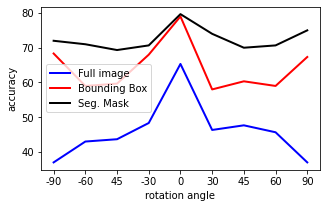

In [84]:
fig = plt.figure(figsize=[5, 3])
plt.plot(full_rot*100, color='b', linewidth=2)
plt.plot(box_rot*100, color='r', linewidth=2)
plt.plot(seg_rot*100, color='k', linewidth=2)
plt.xlabel('rotation angle')
plt.ylabel('accuracy')
plt.xticks(np.arange(full_rot.shape[0]),['-90', '-60', '45', '-30', '0', '30', '45', '60', '90'])
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])


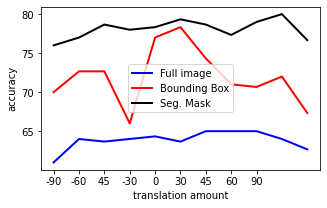

In [85]:
fig = plt.figure(figsize=[5, 3])
plt.plot(full_trans*100, color='b', linewidth=2)
plt.plot(box_trans*100, color='r', linewidth=2)
plt.plot(seg_trans*100, color='k', linewidth=2)
plt.xlabel('translation amount')
plt.ylabel('accuracy')
plt.xticks(np.arange(full_rot.shape[0]),['-90', '-60', '45', '-30', '0', '30', '45', '60', '90'])
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])
